# Laboratoire 7
## Lidar, ICP et mapping

Ce laboratoire consiste à vous familiariser avec l'utilisation et le comportement de l'algorithme *Iterative Closest Point*. L'idée est d'aligner des scans lasers consécutifs de façon à construire une carte 2D de l'environnement. Notez qu'il ne s'agit pas ici de faire du SLAM, mais bien de simplement aligner des scans consécutifs sans faire de vérification ou ajustement par la suite.

![Le lidar Hokuyo](img/hokuyo.jpg)

Le scanner Hokuyo URG-04LX-UG01 possède un champ de vision horizontal de 270 degrés et une portée de 0.02 à 5.6 m. Placez les obstacles à l'intérieur de cette zone pendant la création de votre carte!

### Partie 1 - Afficher un scan

D'abord la poutine préliminaire habituelle.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib nbagg

import time
import numpy as np
import matplotlib.pyplot as plt

from robmob.icp import icp
from robmob.icp_orig import icp as icp_orig
from robmob.robot import Robot
from robmob.sensors import HokuyoSensor, FullOdomSensor

In [2]:
robot = Robot('192.168.0.108')
robot.connect()

In [3]:
hokuyo = HokuyoSensor()
robot.add_sensor(hokuyo)

La fonction `hokuyo_to_3d_homogeneous_matrix` accepte un scan du Hokuyo et le transforme en une matrice Nx4 de points 3D (en coordonnées homogènes). Elle fait simplement la conversion de coordonnées polaires à cartésiennes. Comme le Hokuyo est un scanneur 2D, la fonction fixe simplement la coordonnée en $z$ comme étant égale à 0.

In [4]:
def hokuyo_to_3d_homogeneous_matrix(hokuyo_data):
    ranges = np.array(hokuyo_data['ranges'])
    thetas = np.arange(hokuyo_data['angle_min'], hokuyo_data['angle_max']+hokuyo_data['angle_increment'], hokuyo_data['angle_increment'])
    xs = ranges * np.cos(thetas)
    ys = ranges * np.sin(thetas)
    
    pts = np.vstack((xs, ys, np.zeros(xs.shape), np.ones(xs.shape))).T
    
    # Remove the points that are at the origin.
    pts = pts[np.nonzero(np.logical_or(pts[:,0] != 0., pts[:,1] != 0.))]
    
    return pts

In [ ]:
pointcloud = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
pointcloud

La fonction `plot_point_clouds` accepte *une liste* de ces matrices et les trace sur un graphique. Le graphique est dans le repère de coordonnées du lidar, ce qui veux dire que les $x$ positifs pointent vers l'arrière du robot.

In [5]:
def plot_point_clouds(pcls):
    STYLES = ['r+', 'bx', 'g*', 'md', 'y_']
    
    for i, pcl in enumerate(pcls):
        plt.plot(pcl[:,0], pcl[:,1], STYLES[i], label='Nuage {}'.format(i))
        plt.plot([0.0], [0.0], 'ko')
        
    plt.axis('equal')
    plt.legend()
    plt.show()

In [ ]:
plot_point_clouds([pointcloud])

### Utiliser ICP

Nous avons une implémentation (un peu primitive) de l'algorithme ICP dans la librairie `robmob`. Pour l'utiliser, il faut appeler la fonction `icp`. Elle prend deux nuages de points en arguments et retourne une transformation homogène `H` qui exprime la position du premier nuage de point dans le repère de coordonnées du second. 

`icp` retourne aussi `err`, un vecteur qui donne la distance entre chaque paire de points associés. Ce vecteur est utile pour savoir si l'algorithme `icp` a bien convergé ou bien si le résultat laisse à désirer.

Pour tester l'algorithme, capturez un scan, déplacez le robot et capturez un autre scan.

> **PROTIP** Utilisez le fichier [Controller.ipynb](Controller.ipynb) pour déplacer le robot.

In [ ]:
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [ ]:
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [ ]:
H, err = icp(pcl1, pcl2)

In [ ]:
H

In [ ]:
print('La distance moyenne entre les points associés est de {} m'.format(np.average(err)))

Avec la matrice H en main, il est possible de déplacer le nuage `pcl1` de sorte qu'il soit dans le repère de coordonnées de `pcl2`. Complétez la fonction `apply_transformation_to_pcl`. 

In [10]:
def pcl_with_transformation_applied(H, pcl):
    '''
    Apply an homogeneous transformation to a pointcloud.
    Input
        H: A 4x4 matrix describing an homogeneous geometric transformation.
        pcl: A Nx4 matrix containing the points to be displaced.
    Output
        transformed_pcl: A Nx4 matrix contaning the displaced points.
    '''
    return (H.dot(pcl.T)).T

L'appel suivant va tracer les deux nuages de points originaux, ainsi que le nuage de points déplacé. Nuage 0 est le nuage original, Nuage 1 est le nuage objectif, et Nuage 2 est une copie de Nuage 0 déplacée vers Nuage 1.

> **PROTIP** Les graphiques de ce TP sont difficiles à lire. Souvenez-vous, l'objectif est de partir de `pcl1` et de venir le coller vers `pcl2`. Par exemple, dans le cas présent, Nuage 0 est le nuage d'origine et Nuage 2 sa version déplacée. Donc Nuage 2 devrait être identique à Nuage 0, mais collé sur Nuage 1.

In [ ]:
plot_point_clouds([pcl1, pcl2, pcl_with_transformation_applied(H, pcl1)])

> **Question** Est-ce que l'algorithme ICP est meilleur pour détecter les rotations ou les translations? Testez l'algorithme avec différentes rotations entre les deux scans, puis refaites l'expérience avec différentes translations entre les deux scans.

> **Question** Selon vos résultats à la question précédente, est-ce que l'ICP est capable de bien détecter de grandes transformations géométriques?

### Estimé initial

L'ICP est efficace pour trouver de petites transformations. Si on essaie de couvrir de trop grandes distances d'un scan à l'autre, l'ICP risque de tomber dans un minimum local. Pour cette raison c'est une bonne pratique de faire un estimé initial de la transformation $H$ que l'on cherche avant de lancer l'ICP. On pourrait se servir de l'odométrie, par exemple. La fonction suivante applique un estimé initial à un des nuages de points avant d'appeler ICP.

In [ ]:
def icp_with_initial_estimate(pcl1, pcl2, estimate):
    '''
    Do ICP with an initial estimate.
    Input
        pcl1, pcl2: The point clouds to be matched. Nx4 matrices.
        estimate: A 4x4 homogeneous transformation that represents our estimate of the robot displacement.
    Output
        H: A 4x4 homogeneous transformation that represents the ICP-adjusted displacement between the two PCLs.
        err: A vector containing the distance between the matched points.
    '''
    pcl1_with_estimation = pcl_with_transformation_applied(estimate, pcl1)
    H, err = icp(pcl1_with_estimation, pcl2)
    
    return H.dot(estimate), err

In [ ]:
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

Avant de capturer le prochain scan, avancez le robot de 0.5 m dans la direction $x$ du lidar.

In [ ]:
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [ ]:
# On estime que le robot a avancé de 0.5m vers l'avant *du lidar*.
estimate = np.array([[1.0, 0.0, 0.0, 0.2],
                     [0.0, 1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0]])

H, err = icp_with_initial_estimate(pcl1, pcl2, estimate)
print(H)
print('La distance moyenne entre les points associés est de {} m'.format(np.average(err)))

Une fois de plus, ce graphique est difficile à lire. L'objectif est de coller Nuage 0 sur Nuage 1. Nuage 2 est une version de Nuage 1 qui est déplacé selon notre estimé initial. Nuage 2 n'a donc jamais passé par l'ICP. Nuage 3 est une version de nuage 0 qui a été déplacée selon le résultat de l'ICP.

In [ ]:
pcl1_with_estimate = pcl_with_transformation_applied(estimate, pcl1)
pcl1_after_icp = pcl_with_transformation_applied(H, pcl1)

plot_point_clouds([pcl1, pcl2, pcl1_with_estimate, pcl1_after_icp])

> **Question** Est-ce que d'ajouter un estimé initial a aidé l'algorithme ICP à mieux converger dans le cas présent? Est-ce que l'ICP est capable de détecter correctement de plus grandes transformations géométriques avec un estimé initial?

### Estimé initial grâce à l'odométrie

Il serait plus astucieux de se servir de l'odométrie pour faire un estimé initial, plutôt que de demander à un humain de le faire. La fonction `homogeneous_transformation_of_two_poses` trouve la matrice 4x4 de transformation homogène qui passe d'une position à l'autre.

In [ ]:
def homogeneous_transformation_of_two_poses(pose1, pose2):
    dx = pose2[0] - pose1[0]
    dy = pose2[1] - pose1[1]
    dtheta = pose2[2] - pose1[2]
    
    return np.array([[np.cos(dtheta), -1*np.sin(dtheta), 0.0, dx],
                       [np.sin(dtheta), np.cos(dtheta), 0.0, dy],
                       [0.0, 0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0]])

Le bloc suivant nous abonne aux données d'odométrie. Ensuite on peut collecter l'estimé d'odométrie en même temps que l'on connecte des scans lidar.

In [ ]:
odom_sensor = FullOdomSensor()
robot.add_sensor(odom_sensor)

In [ ]:
pose1 = odom_sensor.peek_data()
pcl1 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [ ]:
pose2 = odom_sensor.peek_data()
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [ ]:
odom_estimate = homogeneous_transformation_of_two_poses(pose1, pose2)
odom_estimate

In [ ]:
# ICP sans estimé d'odométrie.
H_without_estimate, err = icp(pcl1, pcl2)
H_without_estimate

In [ ]:
# ICP avec estimé d'odométrie.
H, err = icp_with_initial_estimate(pcl1, pcl2, odom_estimate)
H

Le graphique suivant est encore plus difficile à lire, donc allez-y pas à pas. Nuage 0 est le nuage original, et Nuage 1 notre objectif. Nuage 2 est une version de nuage 0 déplacée selon notre estimé d'odométrie. Nuage 3 est une version de Nuage 0 déplacée selon l'icp avec estimé initial. Nuage 4 est une version de nuage 0 déplacé selon l'icp sans estimé initial.

In [ ]:
pcl1_with_estimate = pcl_with_transformation_applied(odom_estimate, pcl1)
pcl1_after_icp = pcl_with_transformation_applied(H, pcl1)
pcl1_after_lesser_icp = pcl_with_transformation_applied(H_without_estimate, pcl1)

plot_point_clouds([pcl1, pcl2, pcl1_with_estimate, pcl1_after_icp, pcl1_after_lesser_icp])

### Construction d'une carte

Pour construire une carte de l'environnement avec le lidar, il faut intégrer tous les outils utilisés jusqu'à présent. La boucle suivante additionne les transformations successives détectées par l'ICP. On peut donc suivre le déplacement du robot dans l'environnement. 

Malheureusement l'algorithme d'ICP dont on dispose ne permet pas de faire l'ICP d'un scan lidar contre toute la carte construite. Il faut donc additionner les transformations du premier scan vers le deuxième, du deuxième vers le troisième, etc. La conséquence de cela est qu'un ICP de mauvaise qualité va affecter toutes les positions estimées successives. C'est un peu comme faire de la navigation à l'aveugle avec l'odométrie.

Mean distance between associated points: 0.0
0.0000
Mean distance between associated points: 0.002848151050336851
Mean distance between associated points: 0.002851881266714294
0.0001
Mean distance between associated points: 0.0028758125691885376
Mean distance between associated points: 0.002856725363476843
0.0000
Mean distance between associated points: 0.002855466819310832
Mean distance between associated points: 0.002864917432163488
0.0002
Mean distance between associated points: 0.0027105805287099913
Mean distance between associated points: 0.0027127647600868306
0.0003
Mean distance between associated points: 0.0030059521583320403
Mean distance between associated points: 0.003007774511736442
0.0001
Mean distance between associated points: 0.0030510443681108558
Mean distance between associated points: 0.003038212180592457
0.0001
Mean distance between associated points: 0.002959272948437015
Mean distance between associated points: 0.0029732698899110326
0.0005
Mean distance between ass

<IPython.core.display.Javascript object>


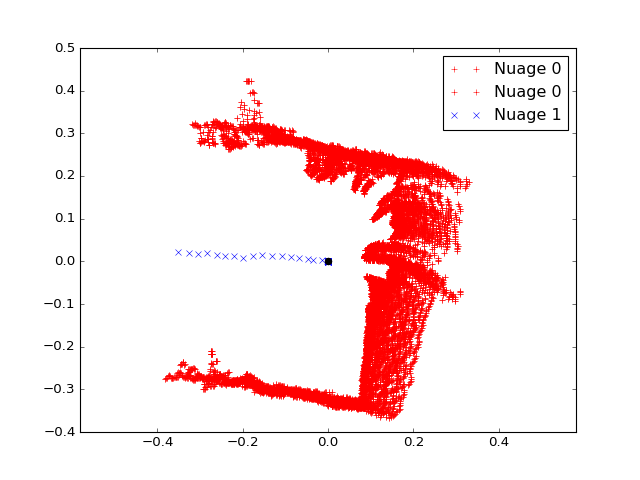

In [19]:
# Le premier scan va servir de base à notre carte. On va y ajouter les scans suivants.
built_map = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
previous_reading = built_map.copy()

sum_of_H = np.eye(4)
lidar_positions = np.array([[0.0, 0.0, 0.0, 1.0]]) # On considère que la position initiale du lidar est l'origine.
clouds = []
clouds.append(previous_reading)

for i in range(30):
    # Prendre une lecture du lidar.
    reading = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
    clouds.append(reading)
    
    # Exécuter ICP
    H, err = icp(reading, previous_reading)
    print('{:0.4f}'.format(np.linalg.norm(H[0:1, 3])))
    
    # Ajouter la transformation trouvée à notre somme de transformations.
    sum_of_H = H.dot(sum_of_H)
    
    # Mettre à jour la position du robot.
    previous_position = robot_positions[-1,:]
    new_position = sum_of_H.dot(np.array([0.0, 0.0, 0.0, 1.0]).T).T
    lidar_positions = np.vstack((robot_positions, new_position))
    
    # Ajouter le scan déplacé à la carte
    displaced_reading = pcl_with_transformation_applied(sum_of_H, reading)
    built_map = np.concatenate((built_map, displaced_reading), axis=0)
    
    previous_reading = reading
    
    time.sleep(0.15)
    
plot_point_clouds([built_map])

In [20]:
plot_point_clouds([built_map, robot_positions])

In [18]:
sum_of_H

array([[ 0.9946866 , -0.10294938,  0.        ,  0.13765905],
       [ 0.10294938,  0.9946866 ,  0.        , -0.00693581],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])